In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
from collections import Counter, defaultdict
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns
import zipfile

In [2]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set random seeds for reproducibility
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
!pip install -U datasets huggingface_hub fsspec

### Loading the dataset

Changed this to the EuroSAT ds available on hugging face dataset to save loading time.

In [5]:
# Load the EuroSAT dataset directly from Hugging Face
print("Loading dataset...")
dataset = load_dataset("jonathan-roberts1/EuroSAT")
print(dataset)

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

(…)-00000-of-00001-26e80b6de2d4dca7.parquet:   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


In [6]:
# Create train-validation split
train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=8
)

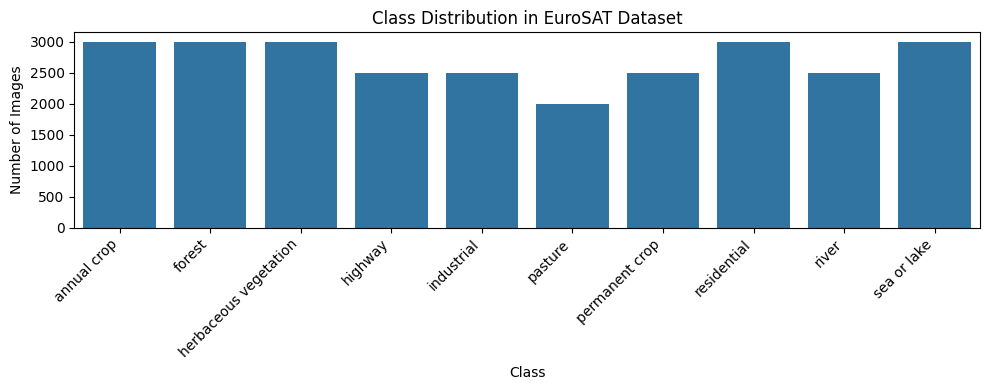

Class Percentage  Number of Images
0            annual crop     11.11%              3000
1                 forest     11.11%              3000
2  herbaceous vegetation     11.11%              3000
3                highway      9.26%              2500
4             industrial      9.26%              2500
5                pasture      7.41%              2000
6         permanent crop      9.26%              2500
7            residential     11.11%              3000
8                  river      9.26%              2500
9            sea or lake     11.11%              3000

In [15]:
# Checking Ratios

from collections import Counter
import pandas as pd

# Count labels
labels = dataset["train"]["label"]
label_names = dataset["train"].features["label"].names
label_counts = Counter(labels)

# Build DataFrame for display
total = sum(label_counts.values())
df = pd.DataFrame([
    {"Class": label_names[i],
     "Percentage": f"{(count / total) * 100:.2f}%",
     "Number of Images": count}
    for i, count in sorted(label_counts.items())
])

# Display as a table
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.barplot(data=df, x="Class", y="Number of Images")
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in EuroSAT Dataset")
plt.tight_layout()
plt.show()

# Show DataFrame
import IPython.display as disp
disp.display(df)

Images were preprocessed using a standard pipeline for transfer learning with ImageNet-pretrained models. First, the EuroSAT images were resized from their native 64×64 resolution to 224×224 pixels to match the input requirements of the Wide ResNet50 architecture. The pixel values were then converted to tensors and normalized using ImageNet's channel-wise mean (0.485, 0.456, 0.406) and standard deviation (0.229, 0.224, 0.225) to ensure compatibility with the pretrained weights. This preprocessing approach is critical when leveraging transfer learning, as it aligns the input distribution with what the pretrained network expects, allowing effective feature extraction from the early convolutional layers despite the domain shift between natural images and satellite imagery.

In [16]:
# Function to visualize class distribution
def plot_class_distribution(labels, title, label_names=None):
    if label_names is None:
        label_names = dataset["train"].features["label"].names

    # Count and build DataFrame
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    df = pd.DataFrame([
        {
            "Class": label_names[i] if isinstance(i, int) else i,
            "Percentage": f"{(count / total) * 100:.2f}%",
            "Number of Images": count
        }
        for i, count in sorted(label_counts.items())
    ])

    # Plot bar chart
    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="Class", y="Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Display the table
    return df

We define the ResNet-18 model

In [11]:
# Define the ResNet-18 model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNet18Classifier, self).__init__()

        # For newer PyTorch versions (1.13+)
        try:
            self.model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        except:
            # Fallback for older versions
            self.model = models.resnet18(pretrained=pretrained)

        # Replacing the final fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In our implementation, we created a custom EuroSATDataset class that inherits from PyTorch's Dataset, providing an efficient interface between our raw satellite imagery and the training pipeline. This class handles the application of image transformations and maintains the train-validation split through indexing, allowing flexible access to different subsets of the data. We then instantiated separate training and validation datasets with their respective transformations, and wrapped them in DataLoaders with a batch size of 32. The training loader incorporates shuffling to improve model generalization, while the validation loader maintains deterministic ordering. This approach enables efficient batched processing and parallelized data loading, which is essential for training deep convolutional networks like Wide ResNet50 on large image datasets.

In [12]:
# Create PyTorch datasets
class EuroSATDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

In [11]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1

Our implementation establishes a comprehensive training framework with integrated early stopping to prevent overfitting on the EuroSAT dataset. The training loop executes up to 30 epochs, with patience set to 5 epochs for early termination if validation accuracy fails to improve. Within each epoch, we conduct a full training pass using our train_one_epoch function, followed by validation with the validate function, while systematically applying learning rate adjustments via the cosine annealing scheduler. Performance metrics including loss, accuracy, and F1-score are tracked for both training and validation sets and stored in a history dictionary for subsequent analysis. We save the model weights only when validation accuracy improves, maintaining the best-performing configuration throughout training.

In [12]:
# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, patience=7, save_path=None):
    best_val_acc = 0
    counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if save_path:
                torch.save(model.state_dict(), save_path)
            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc

In [13]:
# Function to create dataset with specific synthetic data ratio
def create_synthetic_dataset(train_dataset, synthetic_full, synth_prop, seed=8):
    random.seed(seed)

    # Get all original labels
    orig_labels = [label for _, label in train_dataset]
    orig_counts = Counter(orig_labels)

    # Build a map class_id -> list of synthetic indices
    class_to_syn_idxs = defaultdict(list)
    for idx, (_, lbl) in enumerate(synthetic_full):
        class_to_syn_idxs[lbl].append(idx)

    # For each class, sample synth_prop of the original count from synthetic pool
    syn_sample_idxs = []
    for cls, cnt in orig_counts.items():
        num_to_add = int(synth_prop * cnt)
        available = class_to_syn_idxs[cls]
        if len(available) < num_to_add:
            num_to_add = len(available)
        syn_sample_idxs += random.sample(available, num_to_add)

    # Create a Subset of synthetic data
    synthetic_subset = Subset(synthetic_full, syn_sample_idxs)

    # Combine original train + synthetic subset
    combined_train = ConcatDataset([train_dataset, synthetic_subset])

    print(f" → Original train samples: {len(train_dataset)}")
    print(f" → Synthetic added:       {len(synthetic_subset)}")
    print(f" → Total combined:        {len(combined_train)}")

    return combined_train

Below the full training loop for all configurations

- Using the full EuroSAT dataset:
  - No change
  - Geometric augmentation
  - 5% Synth
  - 10% Synth
  - 20% Synth
  - 30% Synth
  - 40% Synth
  - 50% Synth

Extracting synthetic dataset...
Extraction complete.

Running experiment: No Augmentation


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


Epoch 1/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1931, Train Acc: 0.9395, Train F1: 0.9394
Val Loss: 0.1010, Val Acc: 0.9691, Val F1: 0.9690
Epoch 2/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0563, Train Acc: 0.9812, Train F1: 0.9812
Val Loss: 0.1178, Val Acc: 0.9650, Val F1: 0.9650
Epoch 3/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0346, Train Acc: 0.9887, Train F1: 0.9887
Val Loss: 0.0640, Val Acc: 0.9802, Val F1: 0.9802
Epoch 4/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0236, Train Acc: 0.9926, Train F1: 0.9926
Val Loss: 0.0653, Val Acc: 0.9806, Val F1: 0.9805
Epoch 5/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0155, Train Acc: 0.9950, Train F1: 0.9950
Val Loss: 0.0632, Val Acc: 0.9798, Val F1: 0.9798
Epoch 6/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0130, Train Acc: 0.9958, Train F1: 0.9958
Val Loss: 0.0613, Val Acc: 0.9817, Val F1: 0.9817
Epoch 7/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9977, Train F1: 0.9977
Val Loss: 0.0563, Val Acc: 0.9806, Val F1: 0.9805
Epoch 8/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0075, Train Acc: 0.9976, Train F1: 0.9976
Val Loss: 0.0488, Val Acc: 0.9844, Val F1: 0.9844
Epoch 9/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0031, Train Acc: 0.9993, Train F1: 0.9993
Val Loss: 0.0477, Val Acc: 0.9861, Val F1: 0.9861
Epoch 10/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0028, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0464, Val Acc: 0.9869, Val F1: 0.9868
Epoch 11/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0480, Val Acc: 0.9859, Val F1: 0.9859
Epoch 12/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0029, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0458, Val Acc: 0.9857, Val F1: 0.9857
Epoch 13/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0029, Train Acc: 0.9993, Train F1: 0.9993
Val Loss: 0.0525, Val Acc: 0.9865, Val F1: 0.9865
Epoch 14/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0446, Val Acc: 0.9880, Val F1: 0.9880
Epoch 15/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0423, Val Acc: 0.9889, Val F1: 0.9889
Epoch 16/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0445, Val Acc: 0.9887, Val F1: 0.9887
Epoch 17/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0416, Val Acc: 0.9891, Val F1: 0.9891
Epoch 18/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0428, Val Acc: 0.9880, Val F1: 0.9880
Epoch 19/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0430, Val Acc: 0.9883, Val F1: 0.9883
Epoch 20/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0432, Val Acc: 0.9881, Val F1: 0.9881
Epoch 21/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0431, Val Acc: 0.9885, Val F1: 0.9885
Epoch 22/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0479, Val Acc: 0.9876, Val F1: 0.9876
Epoch 23/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0410, Val Acc: 0.9891, Val F1: 0.9891
Epoch 24/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0427, Val Acc: 0.9894, Val F1: 0.9894
Epoch 25/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0473, Val Acc: 0.9880, Val F1: 0.9880
Epoch 26/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0441, Val Acc: 0.9885, Val F1: 0.9885
Epoch 27/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0027, Train Acc: 0.9994, Train F1: 0.9994
Val Loss: 0.0533, Val Acc: 0.9870, Val F1: 0.9870
Epoch 28/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0018, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0471, Val Acc: 0.9880, Val F1: 0.9880
Epoch 29/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0048, Train Acc: 0.9987, Train F1: 0.9987
Val Loss: 0.0539, Val Acc: 0.9846, Val F1: 0.9846
Epoch 30/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0058, Train Acc: 0.9984, Train F1: 0.9984
Val Loss: 0.0531, Val Acc: 0.9859, Val F1: 0.9859


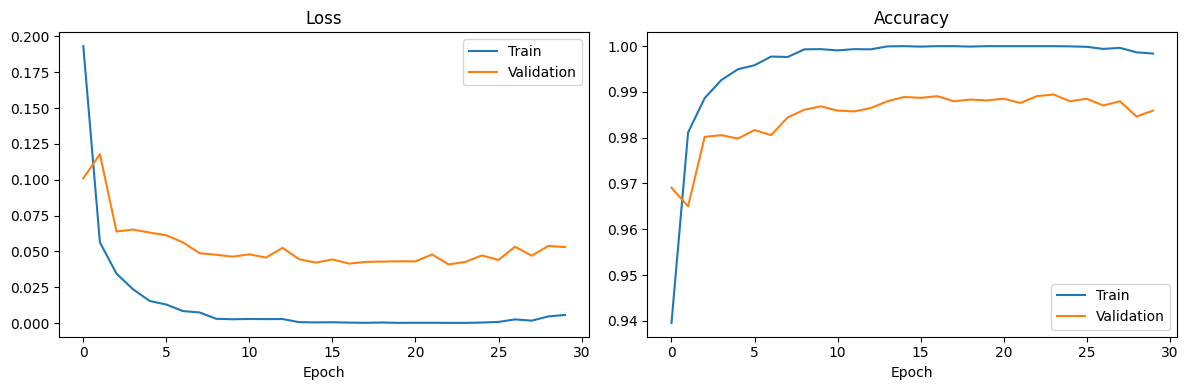

Best validation accuracy: 0.9894

Running experiment: Geometric Augmentation
Epoch 1/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2233, Train Acc: 0.9284, Train F1: 0.9283
Val Loss: 0.0914, Val Acc: 0.9748, Val F1: 0.9748
Epoch 2/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0899, Train Acc: 0.9712, Train F1: 0.9712
Val Loss: 0.0894, Val Acc: 0.9689, Val F1: 0.9690
Epoch 3/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0723, Train Acc: 0.9765, Train F1: 0.9765
Val Loss: 0.0748, Val Acc: 0.9737, Val F1: 0.9738
Epoch 4/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0581, Train Acc: 0.9802, Train F1: 0.9802
Val Loss: 0.0561, Val Acc: 0.9824, Val F1: 0.9824
Epoch 5/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0518, Train Acc: 0.9825, Train F1: 0.9825
Val Loss: 0.0539, Val Acc: 0.9846, Val F1: 0.9846
Epoch 6/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0446, Train Acc: 0.9845, Train F1: 0.9845
Val Loss: 0.0619, Val Acc: 0.9817, Val F1: 0.9817
Epoch 7/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0335, Train Acc: 0.9891, Train F1: 0.9891
Val Loss: 0.0501, Val Acc: 0.9837, Val F1: 0.9837
Epoch 8/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0297, Train Acc: 0.9899, Train F1: 0.9899
Val Loss: 0.0577, Val Acc: 0.9811, Val F1: 0.9811
Epoch 9/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0264, Train Acc: 0.9910, Train F1: 0.9910
Val Loss: 0.0515, Val Acc: 0.9856, Val F1: 0.9855
Epoch 10/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0206, Train Acc: 0.9936, Train F1: 0.9936
Val Loss: 0.0569, Val Acc: 0.9865, Val F1: 0.9865
Epoch 11/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0180, Train Acc: 0.9944, Train F1: 0.9944
Val Loss: 0.0478, Val Acc: 0.9870, Val F1: 0.9870
Epoch 12/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0159, Train Acc: 0.9951, Train F1: 0.9951
Val Loss: 0.0463, Val Acc: 0.9881, Val F1: 0.9881
Epoch 13/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0133, Train Acc: 0.9957, Train F1: 0.9957
Val Loss: 0.0402, Val Acc: 0.9880, Val F1: 0.9880
Epoch 14/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0086, Train Acc: 0.9977, Train F1: 0.9977
Val Loss: 0.0427, Val Acc: 0.9885, Val F1: 0.9885
Epoch 15/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0073, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0414, Val Acc: 0.9878, Val F1: 0.9878
Epoch 16/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0058, Train Acc: 0.9987, Train F1: 0.9987
Val Loss: 0.0399, Val Acc: 0.9898, Val F1: 0.9898
Epoch 17/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0046, Train Acc: 0.9990, Train F1: 0.9990
Val Loss: 0.0392, Val Acc: 0.9906, Val F1: 0.9906
Epoch 18/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0042, Train Acc: 0.9988, Train F1: 0.9988
Val Loss: 0.0386, Val Acc: 0.9900, Val F1: 0.9900
Epoch 19/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 0.9990, Train F1: 0.9990
Val Loss: 0.0386, Val Acc: 0.9907, Val F1: 0.9907
Epoch 20/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0381, Val Acc: 0.9909, Val F1: 0.9909
Epoch 21/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0381, Val Acc: 0.9913, Val F1: 0.9913
Epoch 22/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0034, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0383, Val Acc: 0.9907, Val F1: 0.9907
Epoch 23/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0391, Val Acc: 0.9904, Val F1: 0.9904
Epoch 24/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0034, Train Acc: 0.9993, Train F1: 0.9993
Val Loss: 0.0392, Val Acc: 0.9907, Val F1: 0.9907
Epoch 25/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 0.9993, Train F1: 0.9993
Val Loss: 0.0458, Val Acc: 0.9880, Val F1: 0.9880
Epoch 26/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0046, Train Acc: 0.9988, Train F1: 0.9987
Val Loss: 0.0465, Val Acc: 0.9881, Val F1: 0.9882
Epoch 27/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0565, Val Acc: 0.9852, Val F1: 0.9852
Epoch 28/30


Training:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0084, Train Acc: 0.9978, Train F1: 0.9978
Val Loss: 0.0475, Val Acc: 0.9872, Val F1: 0.9872
Early stopping at epoch 28


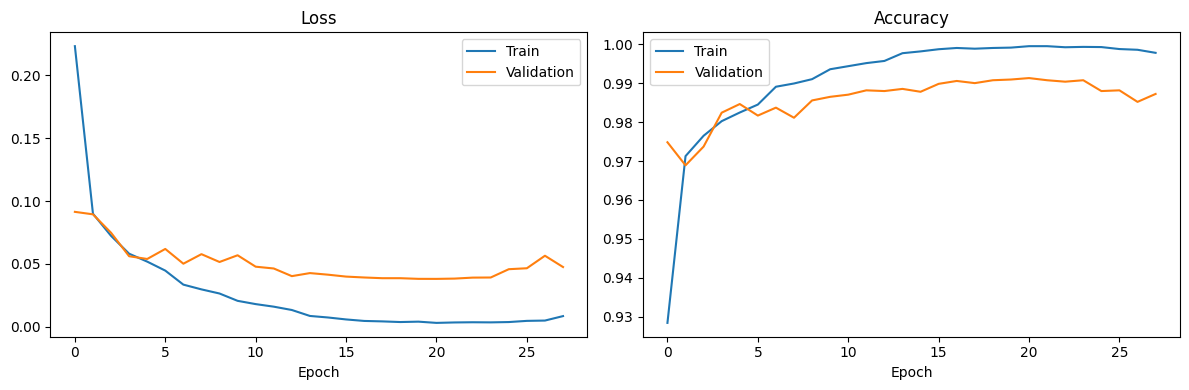

Best validation accuracy: 0.9913

Running experiment: 5% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       1080
 → Total combined:        22680


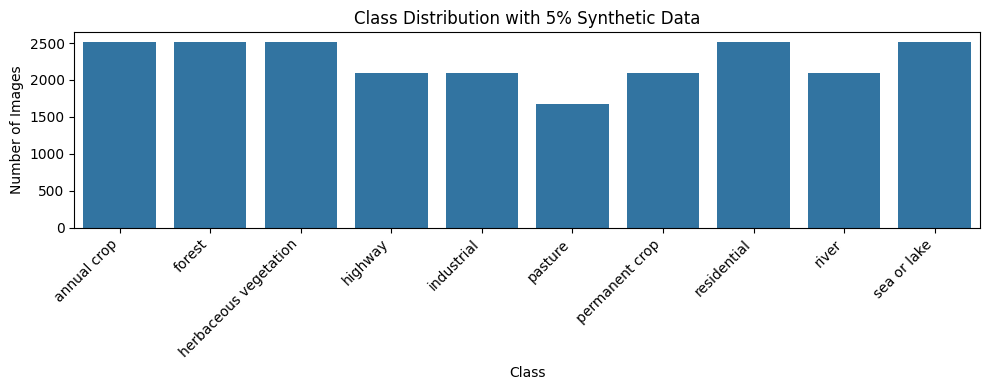

                   Class Percentage  Number of Images
0            annual crop     11.11%              2520
1                 forest     11.11%              2520
2  herbaceous vegetation     11.11%              2520
3                highway      9.26%              2100
4             industrial      9.26%              2100
5                pasture      7.41%              1680
6         permanent crop      9.26%              2100
7            residential     11.11%              2520
8                  river      9.26%              2100
9            sea or lake     11.11%              2520
Epoch 1/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2204, Train Acc: 0.9301, Train F1: 0.9299
Val Loss: 0.0979, Val Acc: 0.9685, Val F1: 0.9686
Epoch 2/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0708, Train Acc: 0.9765, Train F1: 0.9765
Val Loss: 0.0733, Val Acc: 0.9767, Val F1: 0.9766
Epoch 3/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0414, Train Acc: 0.9865, Train F1: 0.9865
Val Loss: 0.0684, Val Acc: 0.9776, Val F1: 0.9776
Epoch 4/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0323, Train Acc: 0.9899, Train F1: 0.9899
Val Loss: 0.0780, Val Acc: 0.9756, Val F1: 0.9756
Epoch 5/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0189, Train Acc: 0.9939, Train F1: 0.9939
Val Loss: 0.0728, Val Acc: 0.9785, Val F1: 0.9785
Epoch 6/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0122, Train Acc: 0.9968, Train F1: 0.9968
Val Loss: 0.0590, Val Acc: 0.9837, Val F1: 0.9837
Epoch 7/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0085, Train Acc: 0.9978, Train F1: 0.9978
Val Loss: 0.0632, Val Acc: 0.9815, Val F1: 0.9815
Epoch 8/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0103, Train Acc: 0.9968, Train F1: 0.9968
Val Loss: 0.0691, Val Acc: 0.9789, Val F1: 0.9789
Epoch 9/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0076, Train Acc: 0.9980, Train F1: 0.9980
Val Loss: 0.0609, Val Acc: 0.9819, Val F1: 0.9819
Epoch 10/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0047, Train Acc: 0.9989, Train F1: 0.9989
Val Loss: 0.0488, Val Acc: 0.9863, Val F1: 0.9863
Epoch 11/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0022, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0547, Val Acc: 0.9857, Val F1: 0.9857
Epoch 12/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0486, Val Acc: 0.9852, Val F1: 0.9852
Epoch 13/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0462, Val Acc: 0.9874, Val F1: 0.9874
Epoch 14/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0446, Val Acc: 0.9869, Val F1: 0.9868
Epoch 15/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0447, Val Acc: 0.9863, Val F1: 0.9863
Epoch 16/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0470, Val Acc: 0.9878, Val F1: 0.9878
Epoch 17/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0452, Val Acc: 0.9874, Val F1: 0.9874
Epoch 18/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0458, Val Acc: 0.9865, Val F1: 0.9865
Epoch 19/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0448, Val Acc: 0.9876, Val F1: 0.9876
Epoch 20/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0443, Val Acc: 0.9876, Val F1: 0.9876
Epoch 21/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0447, Val Acc: 0.9874, Val F1: 0.9874
Epoch 22/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0439, Val Acc: 0.9880, Val F1: 0.9880
Epoch 23/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0467, Val Acc: 0.9880, Val F1: 0.9880
Epoch 24/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0465, Val Acc: 0.9869, Val F1: 0.9868
Epoch 25/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0472, Val Acc: 0.9874, Val F1: 0.9874
Epoch 26/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0485, Val Acc: 0.9870, Val F1: 0.9870
Epoch 27/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0498, Val Acc: 0.9874, Val F1: 0.9874
Epoch 28/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0062, Train Acc: 0.9980, Train F1: 0.9980
Val Loss: 0.0592, Val Acc: 0.9833, Val F1: 0.9833
Epoch 29/30


Training:   0%|          | 0/355 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0522, Val Acc: 0.9848, Val F1: 0.9848
Early stopping at epoch 29


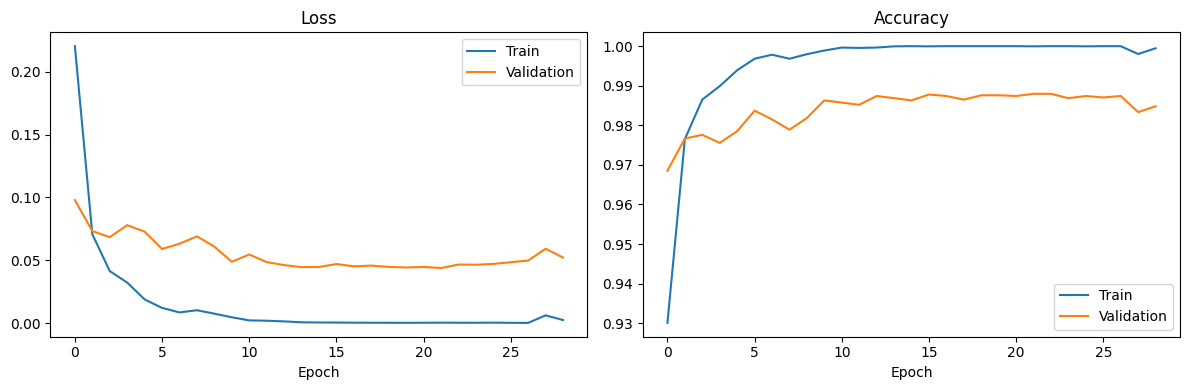

Best validation accuracy: 0.9880

Running experiment: 10% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       2160
 → Total combined:        23760


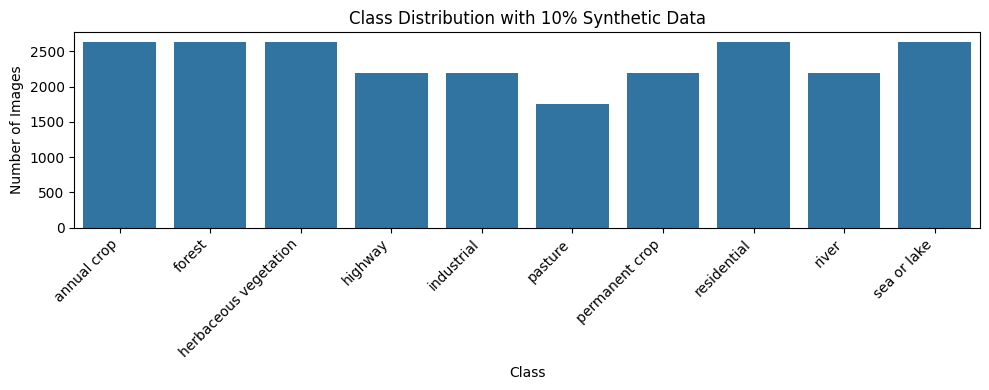

                   Class Percentage  Number of Images
0            annual crop     11.11%              2640
1                 forest     11.11%              2640
2  herbaceous vegetation     11.11%              2640
3                highway      9.26%              2200
4             industrial      9.26%              2200
5                pasture      7.41%              1760
6         permanent crop      9.26%              2200
7            residential     11.11%              2640
8                  river      9.26%              2200
9            sea or lake     11.11%              2640
Epoch 1/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2395, Train Acc: 0.9234, Train F1: 0.9232
Val Loss: 0.1089, Val Acc: 0.9650, Val F1: 0.9649
Epoch 2/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0800, Train Acc: 0.9742, Train F1: 0.9742
Val Loss: 0.0732, Val Acc: 0.9770, Val F1: 0.9770
Epoch 3/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0479, Train Acc: 0.9842, Train F1: 0.9842
Val Loss: 0.0771, Val Acc: 0.9757, Val F1: 0.9758
Epoch 4/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0277, Train Acc: 0.9915, Train F1: 0.9915
Val Loss: 0.0872, Val Acc: 0.9743, Val F1: 0.9742
Epoch 5/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0221, Train Acc: 0.9934, Train F1: 0.9934
Val Loss: 0.0688, Val Acc: 0.9783, Val F1: 0.9784
Epoch 6/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0181, Train Acc: 0.9950, Train F1: 0.9950
Val Loss: 0.0652, Val Acc: 0.9798, Val F1: 0.9798
Epoch 7/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0079, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0633, Val Acc: 0.9826, Val F1: 0.9826
Epoch 8/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0096, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0662, Val Acc: 0.9811, Val F1: 0.9811
Epoch 9/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0105, Train Acc: 0.9971, Train F1: 0.9971
Val Loss: 0.0596, Val Acc: 0.9861, Val F1: 0.9861
Epoch 10/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0597, Val Acc: 0.9841, Val F1: 0.9841
Epoch 11/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0610, Val Acc: 0.9848, Val F1: 0.9848
Epoch 12/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0579, Val Acc: 0.9856, Val F1: 0.9855
Epoch 13/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0524, Val Acc: 0.9859, Val F1: 0.9859
Epoch 14/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0532, Val Acc: 0.9856, Val F1: 0.9856
Epoch 15/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0536, Val Acc: 0.9863, Val F1: 0.9863
Epoch 16/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0537, Val Acc: 0.9865, Val F1: 0.9865
Epoch 17/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0517, Val Acc: 0.9869, Val F1: 0.9868
Epoch 18/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0548, Val Acc: 0.9857, Val F1: 0.9857
Epoch 19/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0515, Val Acc: 0.9869, Val F1: 0.9868
Epoch 20/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0524, Val Acc: 0.9861, Val F1: 0.9861
Epoch 21/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0526, Val Acc: 0.9874, Val F1: 0.9874
Epoch 22/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0522, Val Acc: 0.9876, Val F1: 0.9876
Epoch 23/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0530, Val Acc: 0.9861, Val F1: 0.9861
Epoch 24/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0530, Val Acc: 0.9876, Val F1: 0.9876
Epoch 25/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0529, Val Acc: 0.9874, Val F1: 0.9874
Epoch 26/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0519, Val Acc: 0.9869, Val F1: 0.9869
Epoch 27/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0043, Train Acc: 0.9988, Train F1: 0.9988
Val Loss: 0.0594, Val Acc: 0.9846, Val F1: 0.9846
Epoch 28/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0634, Val Acc: 0.9841, Val F1: 0.9841
Epoch 29/30


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0070, Train Acc: 0.9976, Train F1: 0.9976
Val Loss: 0.0630, Val Acc: 0.9837, Val F1: 0.9837
Early stopping at epoch 29


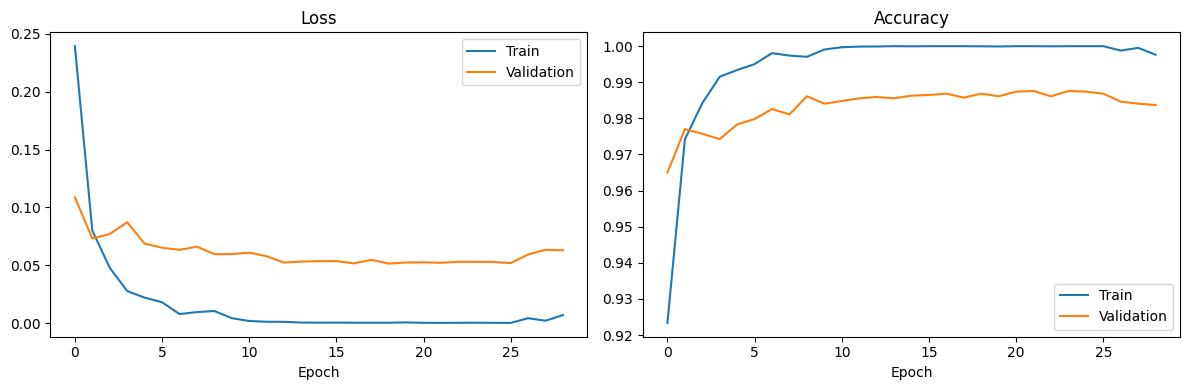

Best validation accuracy: 0.9876

Running experiment: 20% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       4320
 → Total combined:        25920


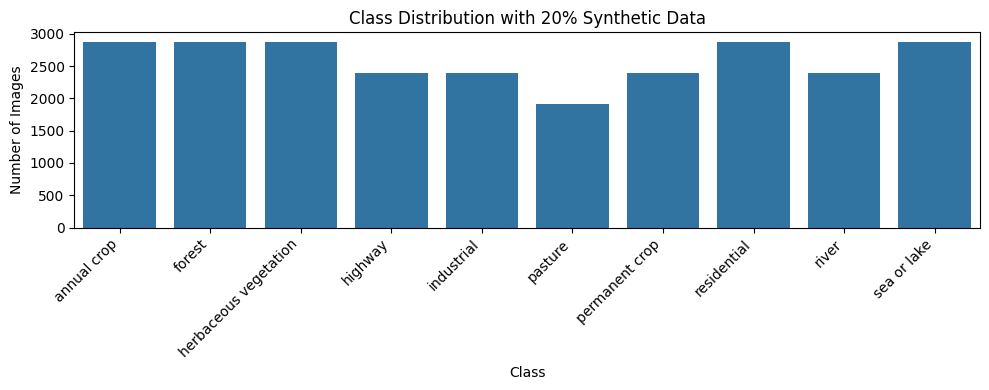

                   Class Percentage  Number of Images
0            annual crop     11.11%              2880
1                 forest     11.11%              2880
2  herbaceous vegetation     11.11%              2880
3                highway      9.26%              2400
4             industrial      9.26%              2400
5                pasture      7.41%              1920
6         permanent crop      9.26%              2400
7            residential     11.11%              2880
8                  river      9.26%              2400
9            sea or lake     11.11%              2880
Epoch 1/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2522, Train Acc: 0.9189, Train F1: 0.9187
Val Loss: 0.0770, Val Acc: 0.9750, Val F1: 0.9750
Epoch 2/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0855, Train Acc: 0.9731, Train F1: 0.9731
Val Loss: 0.0716, Val Acc: 0.9767, Val F1: 0.9766
Epoch 3/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0482, Train Acc: 0.9848, Train F1: 0.9848
Val Loss: 0.0663, Val Acc: 0.9778, Val F1: 0.9778
Epoch 4/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0378, Train Acc: 0.9883, Train F1: 0.9883
Val Loss: 0.0734, Val Acc: 0.9759, Val F1: 0.9760
Epoch 5/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0228, Train Acc: 0.9931, Train F1: 0.9931
Val Loss: 0.0767, Val Acc: 0.9767, Val F1: 0.9767
Epoch 6/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0191, Train Acc: 0.9937, Train F1: 0.9937
Val Loss: 0.0651, Val Acc: 0.9804, Val F1: 0.9803
Epoch 7/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0121, Train Acc: 0.9966, Train F1: 0.9966
Val Loss: 0.0611, Val Acc: 0.9826, Val F1: 0.9826
Epoch 8/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0146, Train Acc: 0.9954, Train F1: 0.9954
Val Loss: 0.0706, Val Acc: 0.9806, Val F1: 0.9805
Epoch 9/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0067, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0656, Val Acc: 0.9819, Val F1: 0.9818
Epoch 10/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0039, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0538, Val Acc: 0.9850, Val F1: 0.9850
Epoch 11/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0039, Train Acc: 0.9986, Train F1: 0.9986
Val Loss: 0.0605, Val Acc: 0.9830, Val F1: 0.9829
Epoch 12/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0547, Val Acc: 0.9844, Val F1: 0.9844
Epoch 13/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0013, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0513, Val Acc: 0.9856, Val F1: 0.9856
Epoch 14/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0505, Val Acc: 0.9857, Val F1: 0.9857
Epoch 15/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0539, Val Acc: 0.9850, Val F1: 0.9850
Epoch 16/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0528, Val Acc: 0.9861, Val F1: 0.9861
Epoch 17/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0523, Val Acc: 0.9859, Val F1: 0.9859
Epoch 18/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0519, Val Acc: 0.9867, Val F1: 0.9867
Epoch 19/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0509, Val Acc: 0.9859, Val F1: 0.9859
Epoch 20/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0506, Val Acc: 0.9863, Val F1: 0.9863
Epoch 21/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0502, Val Acc: 0.9857, Val F1: 0.9857
Epoch 22/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0521, Val Acc: 0.9859, Val F1: 0.9859
Epoch 23/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0524, Val Acc: 0.9852, Val F1: 0.9852
Epoch 24/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0530, Val Acc: 0.9863, Val F1: 0.9863
Epoch 25/30


Training:   0%|          | 0/405 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0518, Val Acc: 0.9863, Val F1: 0.9863
Early stopping at epoch 25


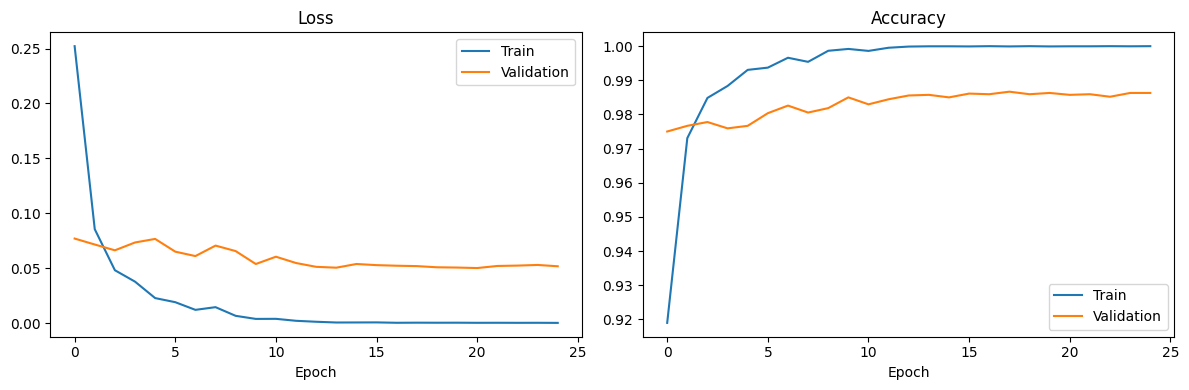

Best validation accuracy: 0.9867

Running experiment: 30% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       6480
 → Total combined:        28080


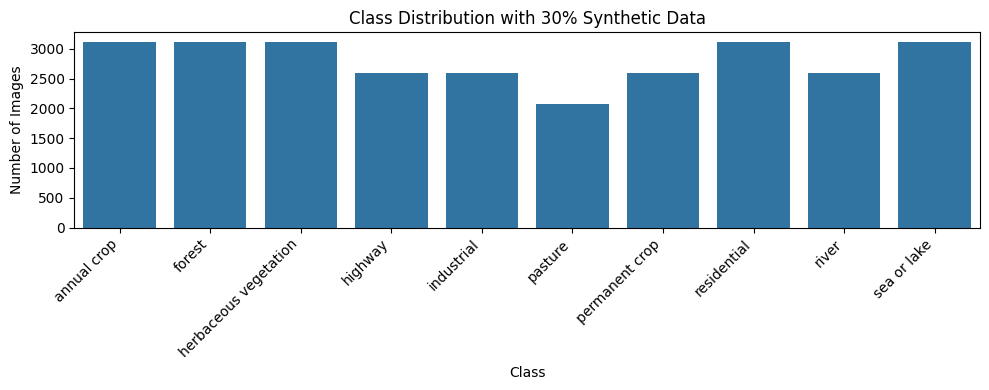

                   Class Percentage  Number of Images
0            annual crop     11.11%              3120
1                 forest     11.11%              3120
2  herbaceous vegetation     11.11%              3120
3                highway      9.26%              2600
4             industrial      9.26%              2600
5                pasture      7.41%              2080
6         permanent crop      9.26%              2600
7            residential     11.11%              3120
8                  river      9.26%              2600
9            sea or lake     11.11%              3120
Epoch 1/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2633, Train Acc: 0.9149, Train F1: 0.9148
Val Loss: 0.1521, Val Acc: 0.9491, Val F1: 0.9490
Epoch 2/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0977, Train Acc: 0.9689, Train F1: 0.9689
Val Loss: 0.0787, Val Acc: 0.9731, Val F1: 0.9731
Epoch 3/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0525, Train Acc: 0.9828, Train F1: 0.9828
Val Loss: 0.0695, Val Acc: 0.9769, Val F1: 0.9769
Epoch 4/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0345, Train Acc: 0.9896, Train F1: 0.9896
Val Loss: 0.0820, Val Acc: 0.9741, Val F1: 0.9740
Epoch 5/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0232, Train Acc: 0.9930, Train F1: 0.9930
Val Loss: 0.0890, Val Acc: 0.9733, Val F1: 0.9734
Epoch 6/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0199, Train Acc: 0.9939, Train F1: 0.9939
Val Loss: 0.0866, Val Acc: 0.9752, Val F1: 0.9752
Epoch 7/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0153, Train Acc: 0.9955, Train F1: 0.9955
Val Loss: 0.0666, Val Acc: 0.9813, Val F1: 0.9813
Epoch 8/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0097, Train Acc: 0.9969, Train F1: 0.9969
Val Loss: 0.0680, Val Acc: 0.9796, Val F1: 0.9796
Epoch 9/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0054, Train Acc: 0.9989, Train F1: 0.9989
Val Loss: 0.0646, Val Acc: 0.9830, Val F1: 0.9830
Epoch 10/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0076, Train Acc: 0.9980, Train F1: 0.9980
Val Loss: 0.0670, Val Acc: 0.9815, Val F1: 0.9815
Epoch 11/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0061, Train Acc: 0.9984, Train F1: 0.9984
Val Loss: 0.0549, Val Acc: 0.9841, Val F1: 0.9841
Epoch 12/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0614, Val Acc: 0.9824, Val F1: 0.9824
Epoch 13/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0571, Val Acc: 0.9831, Val F1: 0.9831
Epoch 14/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0532, Val Acc: 0.9844, Val F1: 0.9844
Epoch 15/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0592, Val Acc: 0.9830, Val F1: 0.9830
Epoch 16/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0530, Val Acc: 0.9850, Val F1: 0.9850
Epoch 17/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0516, Val Acc: 0.9859, Val F1: 0.9859
Epoch 18/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0514, Val Acc: 0.9856, Val F1: 0.9855
Epoch 19/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0525, Val Acc: 0.9861, Val F1: 0.9861
Epoch 20/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0516, Val Acc: 0.9854, Val F1: 0.9854
Epoch 21/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0542, Val Acc: 0.9854, Val F1: 0.9854
Epoch 22/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0542, Val Acc: 0.9848, Val F1: 0.9848
Epoch 23/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0513, Val Acc: 0.9852, Val F1: 0.9852
Epoch 24/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0551, Val Acc: 0.9843, Val F1: 0.9842
Epoch 25/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0546, Val Acc: 0.9848, Val F1: 0.9848
Epoch 26/30


Training:   0%|          | 0/439 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0610, Val Acc: 0.9841, Val F1: 0.9841
Early stopping at epoch 26


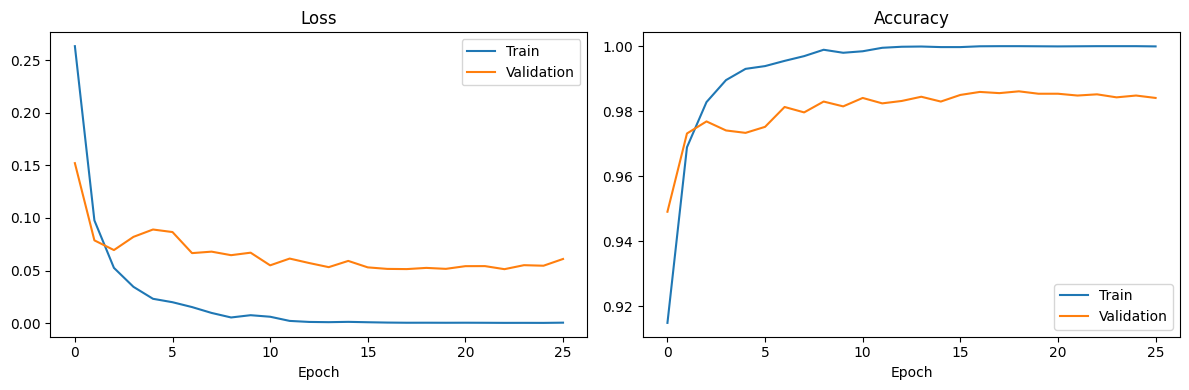

Best validation accuracy: 0.9861

Running experiment: 40% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       8640
 → Total combined:        30240


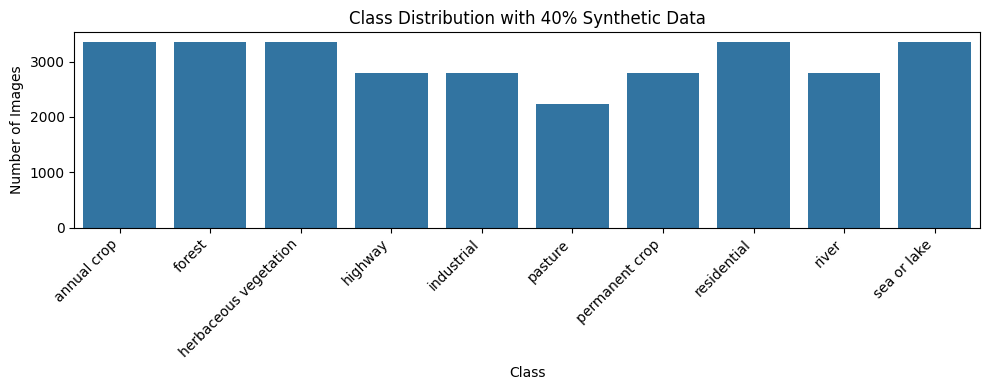

                   Class Percentage  Number of Images
0            annual crop     11.11%              3360
1                 forest     11.11%              3360
2  herbaceous vegetation     11.11%              3360
3                highway      9.26%              2800
4             industrial      9.26%              2800
5                pasture      7.41%              2240
6         permanent crop      9.26%              2800
7            residential     11.11%              3360
8                  river      9.26%              2800
9            sea or lake     11.11%              3360
Epoch 1/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2562, Train Acc: 0.9170, Train F1: 0.9170
Val Loss: 0.0866, Val Acc: 0.9709, Val F1: 0.9710
Epoch 2/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1000, Train Acc: 0.9673, Train F1: 0.9673
Val Loss: 0.0868, Val Acc: 0.9724, Val F1: 0.9724
Epoch 3/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0523, Train Acc: 0.9836, Train F1: 0.9836
Val Loss: 0.0608, Val Acc: 0.9802, Val F1: 0.9802
Epoch 4/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0381, Train Acc: 0.9875, Train F1: 0.9875
Val Loss: 0.0774, Val Acc: 0.9765, Val F1: 0.9765
Epoch 5/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0232, Train Acc: 0.9934, Train F1: 0.9934
Val Loss: 0.0716, Val Acc: 0.9802, Val F1: 0.9802
Epoch 6/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0223, Train Acc: 0.9933, Train F1: 0.9933
Val Loss: 0.0686, Val Acc: 0.9793, Val F1: 0.9792
Epoch 7/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0174, Train Acc: 0.9951, Train F1: 0.9951
Val Loss: 0.0641, Val Acc: 0.9811, Val F1: 0.9811
Epoch 8/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0123, Train Acc: 0.9968, Train F1: 0.9968
Val Loss: 0.0647, Val Acc: 0.9815, Val F1: 0.9815
Epoch 9/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0070, Train Acc: 0.9982, Train F1: 0.9982
Val Loss: 0.0681, Val Acc: 0.9815, Val F1: 0.9815
Epoch 10/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0093, Train Acc: 0.9973, Train F1: 0.9973
Val Loss: 0.0654, Val Acc: 0.9815, Val F1: 0.9815
Epoch 11/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0042, Train Acc: 0.9991, Train F1: 0.9991
Val Loss: 0.0721, Val Acc: 0.9798, Val F1: 0.9798
Epoch 12/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0590, Val Acc: 0.9807, Val F1: 0.9807
Epoch 13/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0018, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0548, Val Acc: 0.9844, Val F1: 0.9844
Epoch 14/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0583, Val Acc: 0.9846, Val F1: 0.9846
Epoch 15/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0611, Val Acc: 0.9837, Val F1: 0.9837
Epoch 16/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0562, Val Acc: 0.9850, Val F1: 0.9850
Epoch 17/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0578, Val Acc: 0.9844, Val F1: 0.9844
Epoch 18/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0562, Val Acc: 0.9850, Val F1: 0.9850
Epoch 19/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0575, Val Acc: 0.9856, Val F1: 0.9855
Epoch 20/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0550, Val Acc: 0.9857, Val F1: 0.9857
Epoch 21/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0555, Val Acc: 0.9857, Val F1: 0.9857
Epoch 22/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0553, Val Acc: 0.9859, Val F1: 0.9859
Epoch 23/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0586, Val Acc: 0.9852, Val F1: 0.9852
Epoch 24/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0548, Val Acc: 0.9865, Val F1: 0.9865
Epoch 25/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0552, Val Acc: 0.9852, Val F1: 0.9852
Epoch 26/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0023, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0620, Val Acc: 0.9850, Val F1: 0.9850
Epoch 27/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0681, Val Acc: 0.9819, Val F1: 0.9818
Epoch 28/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 0.9996, Train F1: 0.9996
Val Loss: 0.0804, Val Acc: 0.9820, Val F1: 0.9820
Epoch 29/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0096, Train Acc: 0.9969, Train F1: 0.9969
Val Loss: 0.0770, Val Acc: 0.9804, Val F1: 0.9804
Epoch 30/30


Training:   0%|          | 0/473 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 0.9984, Train F1: 0.9984
Val Loss: 0.0933, Val Acc: 0.9765, Val F1: 0.9764


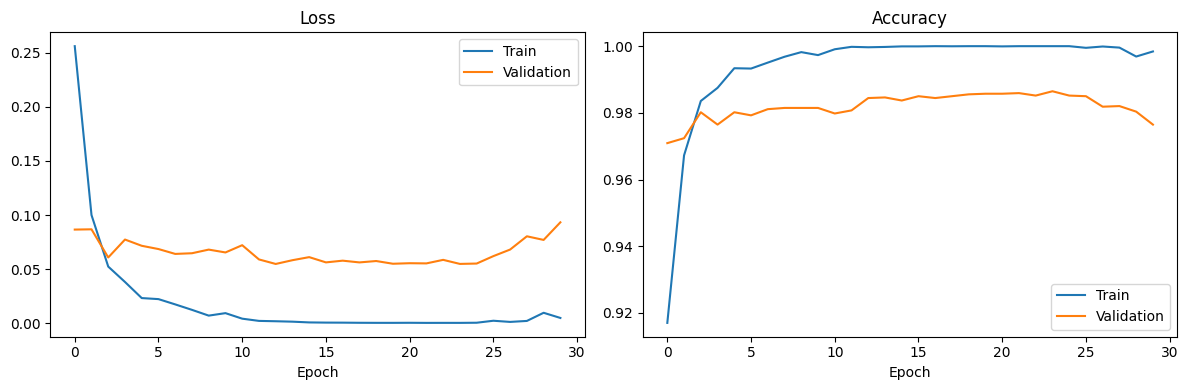

Best validation accuracy: 0.9865

Running experiment: 50% Synthetic Data
 → Original train samples: 21600
 → Synthetic added:       10800
 → Total combined:        32400


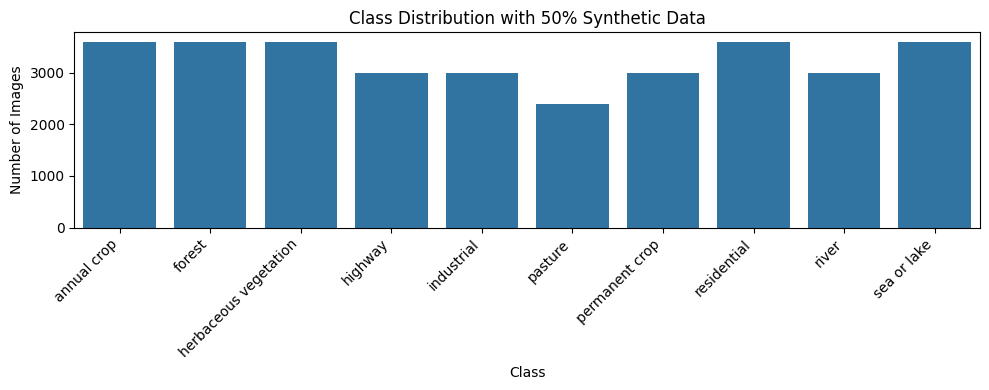

                   Class Percentage  Number of Images
0            annual crop     11.11%              3600
1                 forest     11.11%              3600
2  herbaceous vegetation     11.11%              3600
3                highway      9.26%              3000
4             industrial      9.26%              3000
5                pasture      7.41%              2400
6         permanent crop      9.26%              3000
7            residential     11.11%              3600
8                  river      9.26%              3000
9            sea or lake     11.11%              3600
Epoch 1/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.2641, Train Acc: 0.9123, Train F1: 0.9122
Val Loss: 0.0913, Val Acc: 0.9667, Val F1: 0.9667
Epoch 2/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.1013, Train Acc: 0.9670, Train F1: 0.9670
Val Loss: 0.0791, Val Acc: 0.9737, Val F1: 0.9737
Epoch 3/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0556, Train Acc: 0.9827, Train F1: 0.9827
Val Loss: 0.0858, Val Acc: 0.9724, Val F1: 0.9723
Epoch 4/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0401, Train Acc: 0.9875, Train F1: 0.9875
Val Loss: 0.0867, Val Acc: 0.9717, Val F1: 0.9717
Epoch 5/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0214, Train Acc: 0.9938, Train F1: 0.9938
Val Loss: 0.0748, Val Acc: 0.9781, Val F1: 0.9781
Epoch 6/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0235, Train Acc: 0.9926, Train F1: 0.9926
Val Loss: 0.1104, Val Acc: 0.9643, Val F1: 0.9642
Epoch 7/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0162, Train Acc: 0.9949, Train F1: 0.9949
Val Loss: 0.0792, Val Acc: 0.9769, Val F1: 0.9769
Epoch 8/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0114, Train Acc: 0.9972, Train F1: 0.9972
Val Loss: 0.0641, Val Acc: 0.9809, Val F1: 0.9809
Epoch 9/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0090, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0839, Val Acc: 0.9772, Val F1: 0.9772
Epoch 10/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0049, Train Acc: 0.9987, Train F1: 0.9987
Val Loss: 0.0771, Val Acc: 0.9802, Val F1: 0.9802
Epoch 11/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0066, Train Acc: 0.9981, Train F1: 0.9981
Val Loss: 0.0609, Val Acc: 0.9815, Val F1: 0.9815
Epoch 12/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0031, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0570, Val Acc: 0.9850, Val F1: 0.9850
Epoch 13/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 0.9997, Train F1: 0.9997
Val Loss: 0.0603, Val Acc: 0.9841, Val F1: 0.9841
Epoch 14/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0568, Val Acc: 0.9837, Val F1: 0.9837
Epoch 15/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0576, Val Acc: 0.9844, Val F1: 0.9844
Epoch 16/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 0.9998, Train F1: 0.9998
Val Loss: 0.0611, Val Acc: 0.9837, Val F1: 0.9837
Epoch 17/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0562, Val Acc: 0.9841, Val F1: 0.9841
Epoch 18/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0580, Val Acc: 0.9850, Val F1: 0.9850
Epoch 19/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0543, Val Acc: 0.9856, Val F1: 0.9856
Epoch 20/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0588, Val Acc: 0.9856, Val F1: 0.9855
Epoch 21/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0592, Val Acc: 0.9857, Val F1: 0.9857
Epoch 22/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0576, Val Acc: 0.9863, Val F1: 0.9863
Epoch 23/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0572, Val Acc: 0.9861, Val F1: 0.9861
Epoch 24/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0579, Val Acc: 0.9843, Val F1: 0.9842
Epoch 25/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 1.0000, Train F1: 1.0000
Val Loss: 0.0599, Val Acc: 0.9856, Val F1: 0.9855
Epoch 26/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 0.9999, Train F1: 0.9999
Val Loss: 0.0614, Val Acc: 0.9828, Val F1: 0.9828
Epoch 27/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 0.9995, Train F1: 0.9995
Val Loss: 0.0665, Val Acc: 0.9831, Val F1: 0.9831
Epoch 28/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0028, Train Acc: 0.9992, Train F1: 0.9992
Val Loss: 0.0764, Val Acc: 0.9824, Val F1: 0.9824
Epoch 29/30


Training:   0%|          | 0/507 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Train Loss: 0.0070, Train Acc: 0.9974, Train F1: 0.9974
Val Loss: 0.0766, Val Acc: 0.9820, Val F1: 0.9820
Early stopping at epoch 29


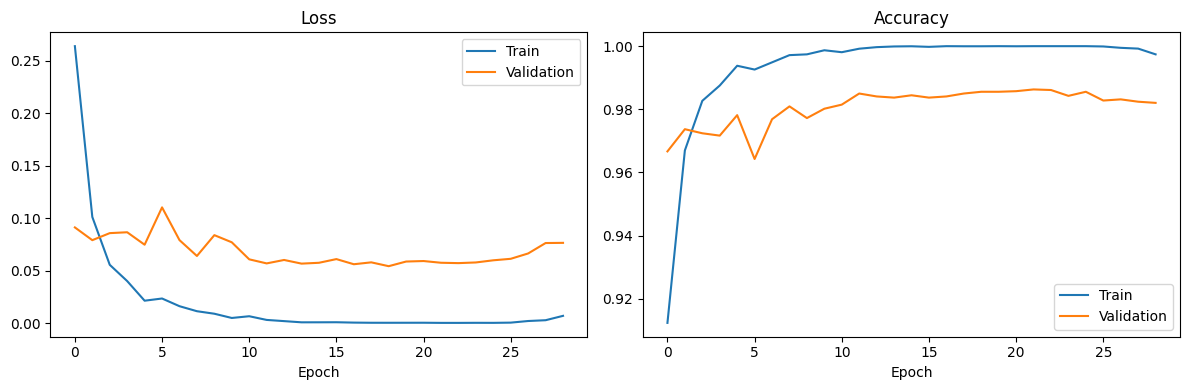

Best validation accuracy: 0.9863


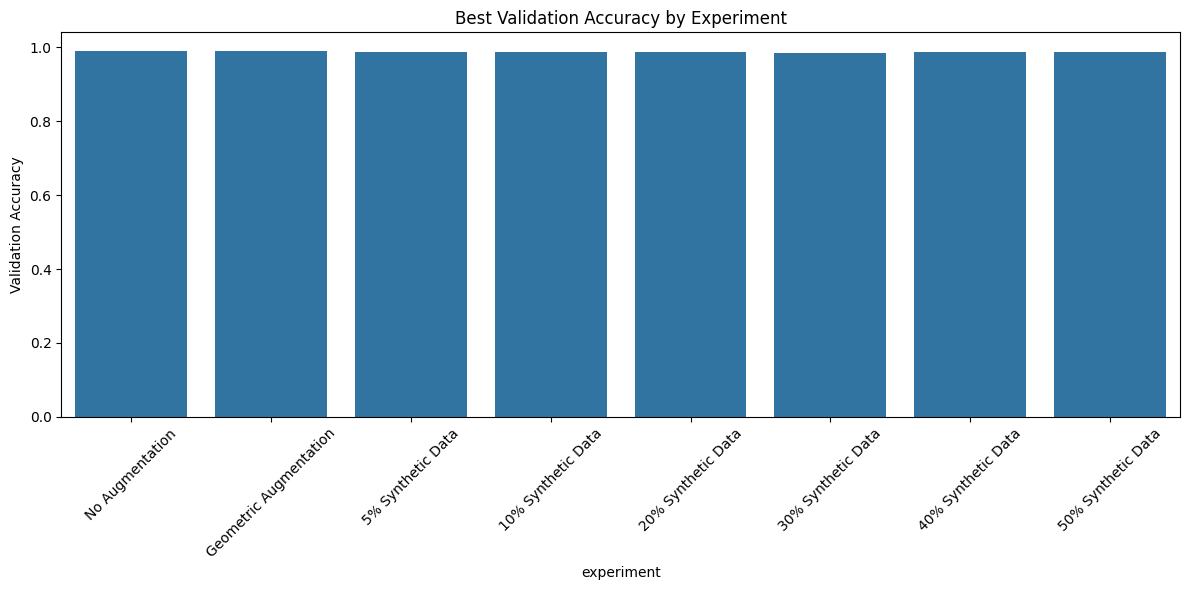

Final results:
               experiment  best_val_acc
0         No Augmentation      0.989444
1  Geometric Augmentation      0.991296
2       5% Synthetic Data      0.987963
3      10% Synthetic Data      0.987593
4      20% Synthetic Data      0.986667
5      30% Synthetic Data      0.986111
6      40% Synthetic Data      0.986481
7      50% Synthetic Data      0.986296


In [14]:
# Main execution
def run_experiments():
    # Define transformations

    # 1. Basic transformation (no augmentation)
    transform_basic = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Geometric augmentation
    transform_geometric = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Standard test transformation (no augmentation)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create base datasets
    base_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_basic)
    geo_train_dataset = EuroSATDataset(train_val_dataset, train_indices, transform_geometric)
    val_dataset = EuroSATDataset(train_val_dataset, val_indices, transform_test)

    # Create validation dataloader (common for all experiments)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

    # Extract synthetic dataset
    print("Extracting synthetic dataset...")
    zip_path = "/content/drive/MyDrive/data/ddpm-generated-images.zip"
    extract_path = "/content/ddpm_generated"

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting synthetic dataset: {e}")
        print("Make sure the path is correct and the file exists")
        return

    # Load synthetic data
    synthetic_full = ImageFolder(
        root=extract_path,
        transform=transform_basic
    )

    # Define different augmentation ratios
    synth_ratios = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50]

    # Store results
    all_results = {
        'experiment': [],
        'best_val_acc': []
    }

    # Run experiment with no augmentation
    print("\n=========================================")
    print("Running experiment: No Augmentation")
    print("=========================================")

    train_loader = DataLoader(base_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path="/content/drive/MyDrive/models/resnet18_no_aug.pth"
    )

    all_results['experiment'].append("No Augmentation")
    all_results['best_val_acc'].append(best_acc)

    # Run experiment with geometric augmentation
    print("\n=========================================")
    print("Running experiment: Geometric Augmentation")
    print("=========================================")

    train_loader = DataLoader(geo_train_dataset, batch_size=64, shuffle=True, num_workers=0)

    model = ResNet18Classifier(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    _, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        save_path="/content/drive/MyDrive/models/resnet18_geo_aug.pth"
    )

    all_results['experiment'].append("Geometric Augmentation")
    all_results['best_val_acc'].append(best_acc)

    # Run experiments with different synthetic data ratios
    for ratio in synth_ratios:
        print(f"\n=========================================")
        print(f"Running experiment: {int(ratio*100)}% Synthetic Data")
        print(f"=========================================")

        # Create dataset with synthetic data
        combined_dataset = create_synthetic_dataset(base_train_dataset, synthetic_full, ratio)
        train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=0)

        # Check class distribution
        combined_labels = [label for _, label in combined_dataset]
        df = plot_class_distribution(combined_labels, f"Class Distribution with {int(ratio*100)}% Synthetic Data")
        print(df)

        model = ResNet18Classifier(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

        _, best_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            save_path=f"/content/drive/MyDrive/models/resnet18_synth_{int(ratio*100)}pct.pth"
        )

        all_results['experiment'].append(f"{int(ratio*100)}% Synthetic Data")
        all_results['best_val_acc'].append(best_acc)

    # Plot final comparison
    results_df = pd.DataFrame(all_results)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='experiment', y='best_val_acc')
    plt.title('Best Validation Accuracy by Experiment')
    plt.ylabel('Validation Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("Final results:")
    print(results_df)

    return results_df

# Run all experiments
if __name__ == "__main__":
    results = run_experiments()

| **Experiment** | **Best Validation Accuracy** |
|----------------|------------------------------|
| No Augmentation | 0.989444 |
| Geometric Augmentation | **0.991296** |
| 5% Synthetic Data | 0.987963 |
| 10% Synthetic Data | 0.987593 |
| 20% Synthetic Data | 0.986667 |
| 30% Synthetic Data | 0.986111 |
| 40% Synthetic Data | 0.986481 |
| 50% Synthetic Data | 0.986296 |